---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
#### Jordileth Bonilla Segura 
#### B41083, Grupo 02
---

# `L5` - *Cadenas de Markov*

> El caso especial de los procesos aleatorios donde existen "estados" y "transiciones" entre estos estados, las cadenas de Markov modelan las probabilidades de transición y el tiempo de permanencia entre cada estado. En particular, la teoría de colas describe la evolución del número de elementos en la fila, dado un flujo de entrada y un flujo de salida.

---

## Sistemas M/M/1

### Problema de ejemplo: un servidor web

> Un servidor web es modelado como un sistema M/M/1 con una tasa de arribo de 2 solicitudes por minuto. Es deseado tener 1 o más solicitudes en fila el 90\% del tiempo. ¿Qué tan rápido debe ser el servicio? $\nu$ es solicitudes atendidas por minuto.

El estado $i$ es el número de clientes en el sistema. La longitud de la fila es $L_q = i - 1$ (*queue length*), en virtud de la solicitud que está siendo atendida en $s = 1$ servidores. Es posible encontrar que:

$$
P( \text{1 o más clientes en el sistema} ) = \sum_{i=1}^{\infty} (1 - \rho) \rho^i  = 1 - \sum_{i=0}^{1} (1 - \rho) \rho^i = \rho
$$

que depende de $\rho = \lambda/\nu$ y del parámetro de servicio $\nu$ buscado. 

De los datos del problema: $\lambda = 2$. Para tener al menos una persona el 90\% del tiempo se necesita:

$$
\begin{aligned}
P( \text{1 o más clientes en el sistema} ) = \rho & = \left( \frac{\lambda}{\nu} \right) \leq 0.1 \\
\nu & \geq \frac{\lambda}{0.1} = \frac{2}{0.1} = 20 \quad \Rightarrow \quad \nu \geq 20
\end{aligned}
$$

es decir, el servidor debe atender más de 20 solicitudes por minuto en promedio para poder satisfacer el requisito.

**Nota**: Observar el cambio de unidades de minutos a segundos, para lograr mayor "granularidad".

Parámetro lambda = 2.0
Parámetro nu = 6.0
Tiempo con más de 1 solicitudes en fila:
	 93.64%
	 Sí cumple con la especificación.
Simulación es equivalente a 8.49 horas.


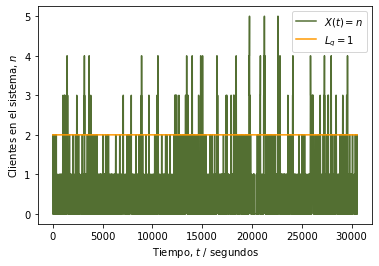

In [24]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Número de clientes
N = 1000

# Parámetro de llegada (clientes/segundos)
lam = 2/60

# Parámetro de servicio (servicios/segundos)
nu = 6/60

# Distribución de los tiempos de llegada entre cada cliente
X = stats.expon(scale = 1/lam)

# Distribución de los tiempos de servicio a cada cliente
Y = stats.expon(scale = 1/nu)

# Intervalos entre llegadas (segundos desde último cliente)
t_intervalos = np.ceil(X.rvs(N)).astype('int')

# Tiempos de las llegadas (segundos desde el inicio)
t_llegadas = [t_intervalos[0]]
for i in range(1, len(t_intervalos)):
    siguiente = t_llegadas[i-1] + t_intervalos[i]
    t_llegadas.append(siguiente)

# Tiempos de servicio (segundos desde inicio de servicio)
t_servicio = np.ceil(Y.rvs(N)).astype('int')

# Inicialización del tiempo de inicio y fin de atención
inicio = t_llegadas[0]          # primera llegada
fin = inicio + t_servicio[0]    # primera salida

# Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
t_atencion = [inicio]
for i in range(1, N):
    inicio = np.max((t_llegadas[i], fin))
    fin = inicio + t_servicio[i]
    t_atencion.append(inicio)

# Inicialización del vector temporal para registrar eventos
t = np.zeros(t_atencion[-1] + t_servicio[-1] + 1)

# Asignación de eventos de llegada (+1) y salida (-1) de clientes
for c in range(N):
    i = t_llegadas[c]
    t[i] += 1
    j = t_atencion[c] + t_servicio[c]
    t[j] -= 1

# Umbral de P o más personas en sistema (hay P - 1 en fila)
P = 3

# Instantes (segundos) de tiempo con P o más solicitudes en sistema
frecuencia = 0.90*len(t)

# Proceso aleatorio (estados n = {0, 1, 2...})
Xt = np.zeros(t.shape)

# Inicialización de estado n
n = 0

# Recorrido del vector temporal y conteo de clientes (estado n)
for i, c in enumerate(t):
    n += c # sumar (+1) o restar (-1) al estado
    Xt[i] = n
    if Xt[i] >= P: 
        frecuencia += 1

# Fracción de tiempo con P o más solicitudes en sistema
fraccion = frecuencia / len(t)

# Resultados
print('Parámetro lambda =', str(lam*60))
print('Parámetro nu =', str(nu*60))
print('Tiempo con más de {} solicitudes en fila:'.format(P-2))
print('\t {:0.2f}%'.format(100*fraccion))
if fraccion >= 0.10:
    print('\t Sí cumple con la especificación.')
else:
    print('\t No cumple con la especificación.') 
print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

# Gráfica de X(t) (estados del sistema)
plt.figure()
plt.plot(Xt, color= "#536F32")
plt.plot(range(len(t)), (P-1)*np.ones(t.shape), color = "#FF9900")
plt.legend(('$X(t) = n$', '$L_q = $' + str(P-2)))
plt.ylabel('Clientes en el sistema, $n$')
plt.xlabel('Tiempo, $t$ / segundos')
plt.show()